## Module 4 Example

The Boston Housing Case



In [0]:
############################Initialization############################
RANDOM_SEED = 1 # seed value for random number generator             
import numpy as np
from scipy import stats as st
import pandas as pd
import seaborn as sns
from matplotlib import rc
import os #manage files
import matplotlib.pyplot as plt  #plots
from matplotlib import rc
import sklearn 
from sklearn.model_selection import train_test_split
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score # evaluation metrics
from sklearn.preprocessing import StandardScaler # used for variable scaling data
from sklearn.preprocessing import MinMaxScaler as Scaler # used for variable scaling data
from sklearn.tree import DecisionTreeRegressor # Regression tree package
from sklearn.ensemble import ExtraTreesRegressor # Extra Trees package (bagging)
from sklearn.ensemble import RandomForestRegressor # Random Forest package
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting package
from sklearn.model_selection import KFold
import sklearn.linear_model 
#####################################################################

## Data Ingest and Curation

In [0]:
mydata=pd.read_csv('boston.csv')
mydata=mydata.drop('neighborhood', 1)
mydata2=mydata.apply(lambda x: x+.01)
mydata3 = mydata2.transform(lambda x: st.boxcox(x)[0])
mydata4 = mydata3.transform(lambda x: (x - x.min()) / (x.max() - x.min()))
cols = mydata4.columns.tolist()
cols = cols[-1:] + cols[:-1]
mydata5=mydata4[cols]
model_data=mydata5.values

In [0]:
# Seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# The model input data outside of the modeling method calls
names = ['DecisionTree_Regression', 'ExtraTrees_Regression', 'RandomForest_Regression', 'GradientBoosting_Regression']

# Specify the set of regression models being evaluated
regressors = [DecisionTreeRegressor(criterion='mse', max_features = 10, random_state=RANDOM_SEED), 
              ExtraTreesRegressor(n_estimators = 100, criterion='mse', max_features = 10, bootstrap=True, n_jobs = -1, random_state = RANDOM_SEED),
              RandomForestRegressor(n_estimators = 100, criterion='mse', max_features = 10, bootstrap=True, n_jobs = -1, random_state = RANDOM_SEED),
              GradientBoostingRegressor(n_estimators = 100, criterion='mse', max_features = 10, random_state=RANDOM_SEED)]

# Random Search

In [4]:
# Establish number of cross folds employed for cross-validation
N_FOLDS = 10

# Setup numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# Check the splitting process by looking at fold observation counts
index_for_fold = 0  # Fold count initialized 
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold, '---------------------------------------------------------------------------------------')

# The structure of modeling data for this study has the response variable coming first and explanatory variables later          
# so 1:model_data.shape[1] slices for explanatory variables and 0 is the index for the response variable    
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]   

    index_for_method = 0  # Method count initialized
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)  # Fit on the train set for this fold
 
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n---------------------------------------------------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')    
print(cv_results_df.mean())


Fold index: 0 ---------------------------------------------------------------------------------------

Fold index: 1 ---------------------------------------------------------------------------------------

Fold index: 2 ---------------------------------------------------------------------------------------

Fold index: 3 ---------------------------------------------------------------------------------------

Fold index: 4 ---------------------------------------------------------------------------------------

Fold index: 5 ---------------------------------------------------------------------------------------

Fold index: 6 ---------------------------------------------------------------------------------------

Fold index: 7 ---------------------------------------------------------------------------------------

Fold index: 8 ---------------------------------------------------------------------------------------

Fold index: 9 ----------------------------------------------------------

# Grid Search

In [5]:
from sklearn.model_selection import GridSearchCV

# Create a base model
rf = RandomForestRegressor()

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

In [6]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test,y_test)

{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Model Performance
Average Error: 0.0609 degrees.
Accuracy = 81.85%.


# Let's Refit the Extra Trees Model and Check Feature Importance


In [0]:
X=mydata5.iloc[:, 1:12].values
y=mydata5.iloc[:,0].values    

In [0]:
myfit=ExtraTreesRegressor(n_estimators = 100, 
                          criterion='mse', 
                          max_features = 3, 
                          max_depth=100,
                          bootstrap=True, 
                          min_samples_leaf=4,
                          min_samples_split=8, 
                          n_jobs = -1, 
                          random_state = RANDOM_SEED)

In [9]:
myfit.fit(X,y)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=100,
                    max_features=3, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=4, min_samples_split=8,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                    oob_score=False, random_state=1, verbose=0,
                    warm_start=False)

In [10]:
print("R^2=",myfit.score(X,y)) # quick R^2
pred= myfit.predict(X)
rmse = sqrt(mean_squared_error(pred, y))
print('RMSE=', rmse)

R^2= 0.7347572455403935
RMSE= 0.09514584214825246


(-1, 11)

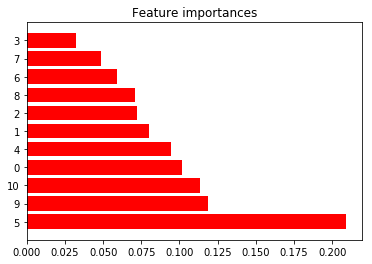

In [11]:
importances=myfit.feature_importances_
std = np.std([myfit.feature_importances_ for tree in myfit.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])

This completes the example for Module 4.

